In [1]:
# all cool packages go here
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from random import randrange
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## MD Langevin

### Part 1, set up the potential and plot it

### The potential is U(x) = 0.5 k (x - x0)^2 and F = -dU(x)/dx|

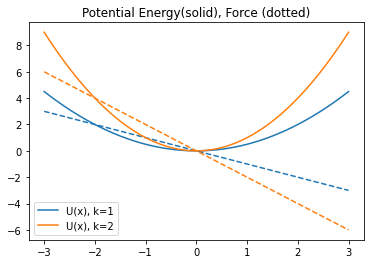

In [2]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
        p = plt.plot(x_points,energies,label=label)
        plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
        plt.legend(loc=0)
        plt.title("Potential Energy(solid), Force (dotted)")
        plt.savefig(str(function)+".png")
        
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

### Now you will implement the BAOAB scheme of Leimkuhler and Matthews (JCP, 2013)

The following equations are repeated (Do B,A,O,A,B then repeat) to move forward in time. The A and B steps represent increments by half a time step.

B: \nu(t)←\nu(t)+\frac{F(t)}{m}(dt/2)

A: x(t)←x(t)+v(t)(dt/2)

The differential equation for the O process is

dv(t)dt=−γvdt+2γkBT/m‾‾‾‾‾‾‾‾√dW

(dW
 is a random differential that samples a gaussian)

Solving this tells us the update rule:

O: v(t)←e−γdtv(t)+R(t)kBT/m‾‾‾‾‾‾√1−e−2γdt‾‾‾‾‾‾‾‾‾√

where R(t)
 is a gaussian random number with mean zero and standard-deviation 1.

In the following, I'm setting the mass m=1

In [3]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        #A
        x = position_update(x,v,dt)

        #O
        v = random_velocity_update(v,gamma,kBT,dt)
        
        #A
        x = position_update(x,v,dt)
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

## Part 3, run Langevin Dynamics simulation of a harmonic oscillator

1) Change my_k and see how it changes the frequency

2) Set my_k=1, and change my_gamma. Try lower values like 0.0001, 0.001, and higher values like 0.1, 1, 10. Do you see how underdamped, low γ
, looks more like standard harmonic oscillator, while overdamped, high γ
 looks more like a random walk?

### Calculate position and velocity

(3333,)
(3333, 1)


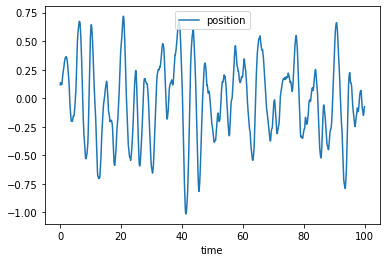

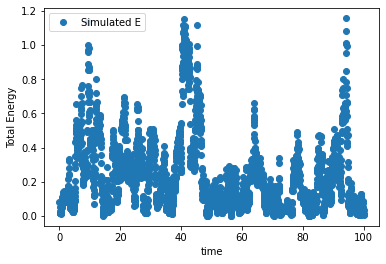

In [4]:
my_k = 2
my_max_time = 100
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=0.25
my_dt=0.01

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, \
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                            k=my_k)

#plt.plot(times,velocities,marker='',label='velocity',linestyle='-')
plt.plot(times,positions,marker='',label='position',linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("harm-v-x.png")
plt.figure()
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()
plt.savefig("harm-e.png")
positions = np.array(positions)
print (np.shape(positions))
training_set = positions.reshape(positions.shape + (1,))
print (np.shape(training_set))

## Part 4, Histogram Position and Velocity
What is the probability of seeing a given position or velocity?

Now we are supposedly sampling the canonical distribution, so we should have:

P(x)=12πkBT/k√e−k(x−x0)22kBT
P
(
x
)
=
1
2
π
k
B
T
/
k
e
−
k
(
x
−
x
0
)
2
2
k
B
T

P(v)=12πkBT/m√e−mv22kBT
P
(
v
)
=
1
2
π
k
B
T
/
m
e
−
m
v
2
2
k
B
T

P(E)=e−E/kBT/∫e−E/kBTdE=1kBTe−E/kBT
P
(
E
)
=
e
−
E
/
k
B
T
/
∫
e
−
E
/
k
B
T
d
E
=
1
k
B
T
e
−
E
/
k
B
T

Set gamma to overdamped above and run the following cell

The histograms will be compared to the exact formulas.

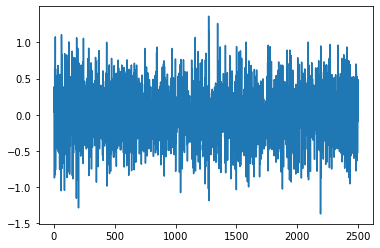

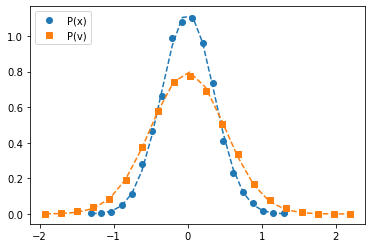

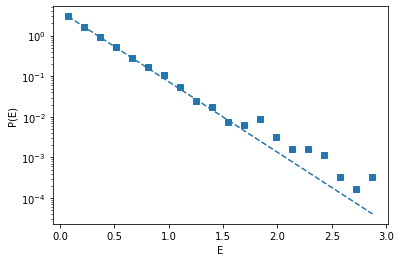

In [5]:
def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.

def gaussian_x(x,k,kBT):
    denominator = np.sqrt(2*np.pi*kBT/k)
    numerator = np.exp(-k*(x**2)/(2*kBT))
    return numerator/denominator

def gaussian_v(v,kBT):
    denominator = np.sqrt(2*np.pi*kBT)
    numerator = np.exp(-(v**2)/(2*kBT))
    return numerator/denominator

#to get a good histogram, we need to run a lot longer than before
my_max_time = 2500

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                             k=my_k)

plt.plot(times,positions,marker='',label='position',linestyle='-')
plt.figure()
#let's only use data from the second half of the trajectory, so it can equilibrate
dist_hist, dist_bin_edges = np.histogram(positions[-len(positions)//2:],bins=20,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities[-len(velocities)//2:],bins=20,density=True)
e_hist, e_bin_edges = np.histogram(total_energies[-len(total_energies)//2:],bins=20,density=True)


ideal_prediction_x = gaussian_x(x=bin_centers(dist_bin_edges),k=my_k,kBT=my_kBT )
p = plt.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')
plt.plot(bin_centers(dist_bin_edges), ideal_prediction_x,linestyle='--',label='', color=p[0].get_color())

ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
p = plt.plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
plt.plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())

plt.legend(loc='upper left')
plt.savefig("harm-hist-Px-Pv.png")
plt.figure()
p = plt.plot(bin_centers(e_bin_edges), e_hist,marker='s',label='P(E)',linestyle='')

#compute the energy histogram values to the boltzman factors for the observed energies
plt.plot(bin_centers(e_bin_edges), np.exp(-bin_centers(e_bin_edges)/my_kBT)/my_kBT,linestyle='--',color=p[0].get_color())
plt.yscale('log')
plt.xlabel("E")
plt.ylabel("P(E)")
plt.savefig("harm-hist-PE.png")

## Now, take X(t) and use LSTM to predict it. This now becomes a time series prediction problem.

 Let us decide the size of the batch and the sequence. To begin with, we will use 4 position points x(t_i), x(t_(i+1)), x(t_(i+2)), x(t_(i+2)) to predict the fifth, namely x(t_(i+4)). In the time series form, the 4 entries become x and the 5th entry becomes y. We will use a sliding window so that there are as many x-entries as y-entries. 
This makes our sequnce length L = 4, and if N is the batch size, then we have N = total tumber of entries in the time series - (sequence length). Here, N = my_max_time - (sequence length), my_max_time being the total number of time points. the -(sequence length) comes from the fact that the first 4 entries cannot be part of y. Also, to predict the last entry in the time value, and to make the size of x and y equal, we cannot have the last entry as part of x. 

### Implement the sliding window for preparing data

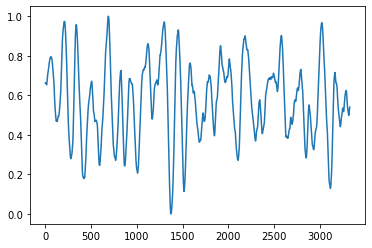

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))
plt.plot(dataY)

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, dev):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

        self.device = dev
        self.lstm.to(dev)
        self.fc.to(dev)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size
        ).to(self.device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size
        ).to(self.device))
        
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [8]:
num_epochs = 40000
learning_rate = 0.05

input_size = 1
hidden_size = 128
num_layers = 1

#num_classes = 1
num_classes = 3600

In [9]:
a = torch.min(dataY)
b = torch.max(dataY)

## Now We create a integer index from the real valued data. The index will have a size num_classes

The data is real spaced and lies between a( = x_min) and b ( = xmax). The index we will create is a set of integers between zero and num_classes (including 0, excluding num_classes). If a data point is given by y and the corresponding index is given by x, then the mapping is linear: y-a = (x-0)*(b-a)/(num_classes-1).  Or, x = (y-a)*(num_classes-1)/(b-1). This produces a real values x. We get the index by taking floor(x). 

In [10]:
# Copy of int-ified training data
int_trainY = torch.floor(
    (trainY - a) / (b - a) * (num_classes - 1)
).clone().detach()
int_trainY = int_trainY.to(torch.long).squeeze()

In [11]:
# Copy of int-ified entire data
int_dataY = torch.floor(
    (dataY - a) / (b - a) * (num_classes - 1)
).clone().detach()
int_dataY = int_dataY.to(torch.long).squeeze()

In [12]:
device = torch.device("cuda:0")
trainX = trainX.to(device)
int_trainY = int_trainY.to(device)

In [13]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

losses = list()
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    loss = criterion(outputs, int_trainY)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()), end="\r")
    losses.append(loss.item())

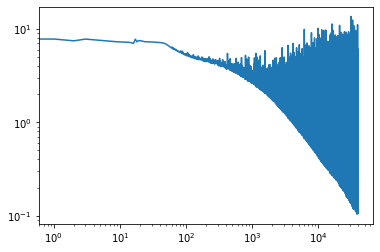

In [14]:
plt.loglog(losses)

In [15]:
lstm.eval()

LSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3600, bias=True)
)

In [16]:
m = nn.Softmax(dim=1)
predict = m(
    lstm(dataX.to(device)).cpu()
).detach().numpy()

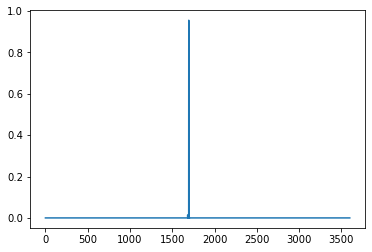

In [17]:
plt.plot(predict[120,:])

In [18]:
def error(data):
    return np.sum(data**2) - data[np.argmax(data)]**2

In [19]:
xt = list()
vt = list()
for i in range(predict.shape[0]):
    xt.append(
        np.argmax(predict[i,:])# *(b-a) + a
    )
    vt.append(
        error(predict[i,:])
    )

Text(0, 0.5, 'position')

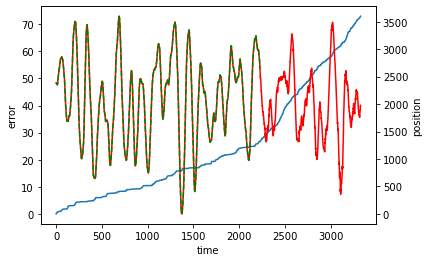

In [20]:
plt.plot(np.cumsum(vt))
plt.xlabel("time")
plt.ylabel("error")
plt.twinx()
plt.plot(xt, color='r')
plt.plot(int_trainY.cpu(), linestyle='dashed',color='g')
plt.ylabel("position")

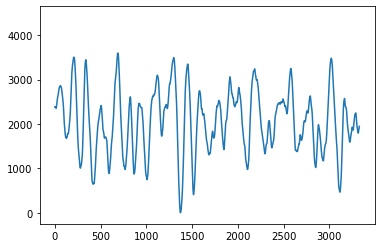

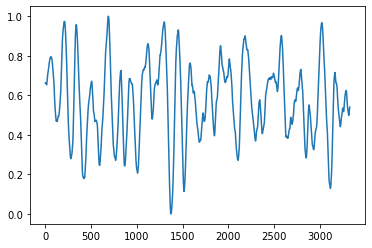

In [21]:
plt.ylim(-250,4650)
plt.plot(int_dataY)
plt.figure()
plt.plot(dataY)

### Old LSTM parameters

In [22]:
#num_embedding = vocab
embedding_dim = 8    # chosen following the nat phys paper
#embedding_dim = 1
#grid_size = N
hidden_size = 8
lstm_unit = 64
#batch_size = 1
#timesteps = 100
num_layers = 1
#output_size=vocab
#output_size= 1

### Do one embedding layer before LSTM

In [23]:
# We do an embedding before LSTM, so we need to know the position grid-size so we know the size of the dictionary for embedding
#Since we have normalized our positions, our grid-size is the same as the size of the array
#embedding = nn.Embedding(num_embedding, embedding_dim)
#dataX = embedding(dataX)
#print (np.shape(trainX))
#print (trainX)
#trainX = embedding(trainX)
#print (np.shape(trainX))
#print (trainX)

In [24]:
# the model
# num_embedding is vocab_size
# hidden_size is hidden_dim
# embedding_dim is input_size

class lanvNet(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, num_layers):
        super(lanvNet, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        # Output dimensionality hidden_dim. That in turn is the input size to LSTM
        #self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        h_0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        
        # propagate input (= output of embedding) through LSTM
        lstm_out, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        #change shape from (batch_size, seq_length, hidden_size) to (batch_size*seq_length, hidden_size)
        linear_in = h_out.view(-1, self.hidden_size)
        #print (np.shape(linear_in))
        # The fully connected linear layer that maps from LSTM hidden state space to LSTM output space
        linear_out = self.fc(linear_in)
        #print (np.shape(linear_out), "linear_out")
        # shape of linear_out is (batch_size*seq_length, output_size)
        out = self.softmax(linear_out)
        #out = linear_out
        
        return out
    